# Term Deposit Marketing - An Apziva Project

# Modeling

By Samuel Alter

Apziva: G3SuQYZYrFt9dwF3

## Project Overview

Using phone call data from a European bank, this project will be building a model that predicts if a customer will subscribe to a term deposit, a type of financial product. This project is a partnership with a startup focused on providing ML solutions for European banks.

### Goals

The startup is hoping that I can **achieve ≥81% accuracy** using a 5-fold cross validation strategy, taking the average performance score.

Bonus goals include:
* Determining which customers are most likely to buy the term deposit loan
  * Which segments of customers should the client prioritize?
* Determine what makes the customer buy the loan
  * Which feature should the startup focus on?

### The dataset

Using phone call data from a European bank, this project will be building models that predict if a customer will subscribe to a term deposit, a type of financial product. This project is a partnership with a startup focused on providing ML solutions for European banks.

The dataset consists of the following columns:
* `age`
  * Numeric
  * The age of the customer
* `job`
  * Categorical
  * The job category of the customer
* `marital`
  * Categorical
  * Whether the customer is married
* `education`
  * Categorical
  * The customer's level of education
* `default`
  * Binary
  * If the customer has credit in default or not
* `balance`
  * Numeric
  * Average yearly balance in Euros
* `housing`
  * Binary
  * If the customer has a housing loan or not
* `loan`
  * Binary
  * If the customer has a personal loan
* `contact`
  * Categorical
  * The type of contact communication
* `day`
  * Numeric
  * Last contact day of the month
* `month`
  * Categorical
  * Last contact month of the year
* `duration`
  * Numeric
  * Duration of the last phone call with the customer
* `campaign`
  * Numeric
  * The number of contacts performed during this campaign and for this client, which includes the last contact

The final column, `y`, is the target of the dataset and shows whether the client subscribed to a term deposit.

## Imports and Helper Functions

In [875]:
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import joblib
import time
import threading
from datetime import datetime
# from contextlib import contextmanager
from timeit import default_timer

from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split,cross_val_score
# from pycaret.classification import setup,compare_models,create_model,plot_model,evaluate_model
# from pycaret.regression import *

# from autosklearn.classification import AutoSklearnClassifier
import optuna

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import roc_curve,auc

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# import sklearn.lda.LDA as LDA # <-- this is throwing the ModuleNotFoundError

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler,SMOTE,SMOTEN
from imblearn.combine import SMOTETomek
from imblearn.metrics import geometric_mean_score

from collections import Counter,defaultdict

from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, fbeta_score
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_validate,cross_val_predict

from sklearn.linear_model import LogisticRegression,SGDClassifier,RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

import warnings
from sklearn.exceptions import ConvergenceWarning,UndefinedMetricWarning
from joblib import Parallel,delayed

import shap

In [7]:
# simple function to generate random integers

def rand_gen(low=1,high=1e4):
    '''
    Generates a pseudo-random integer
    consisting of up to four digits
    '''
    import numpy as np
    rng=np.random.default_rng()
    random_state=int(rng.integers(low=low,high=high))
    
    return random_state

In [8]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    SOURCE: https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

In [9]:
seed=rand_gen()
seed

4769

In [10]:
test_size=0.2
test_size

0.2

In [11]:
# set the randomness seed throughout the notebook
# source: # https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752

## set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)
## set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed)
## set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)
np.random.default_rng(seed)

Generator(PCG64) at 0x16984BAC0

In [12]:
import json
from pathlib import Path
import inspect

def get_variable_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [name for name, val in callers_local_vars if val is var]

def fileDaterSaver(location: str,
                   filetype: str,
                   object_,
                   extra: str = '',
                   verbose: bool = True):

    '''
    Function that gets a timestamped filename and saves it
    to a user-specified location.

    Parameters:
    -----------
    location: str - The location where the file will be saved.
    filetype: str - The type of the file to save ('csv' or 'json').
    object_: The object to be saved. Should be a pandas DataFrame
        for 'csv' or serializable for 'json'.
    extra: str - Additional string to include in the filename.
    verbose: bool - Whether to print verbose messages.
    '''

    # get current date and time
    current_datetime = datetime.now()

    # print current date and time to check
    if verbose:
        print('current_datetime:', current_datetime)

    # format the datetime for a filename
    datetime_suffix = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

    # create filename with the datetime suffix
    if extra != '':
        file_name = f'{location}{extra}_{datetime_suffix}.{filetype}'
    else:
        file_name = f'{location}{datetime_suffix}.{filetype}'

    # print file name
    if verbose:
        print(file_name)

    # save object
    if filetype == 'csv':
        object_.to_csv(file_name, index=True)
    elif filetype == 'json':
        with open(file_name, 'w') as file:
            file.write(json.dumps(object_, default=str))
    else:
        raise ValueError("Unsupported file type. Use 'csv' or 'json'.")

    # confirm save
    file_path = Path(file_name)
    if file_path.exists():
        variable_name = get_variable_name(object_)
        if variable_name:
            print(f'Successfully saved {variable_name[0]} to {file_path}')
        else:
            print(f'Successfully saved object to {file_path}')
    else:
        print("File save error.")

In [13]:
# read in data
df=pd.read_csv('../data/2_data.csv')
df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no


## Goals recap

To achieve this project's goals, we have to run models. As a reminder, this project is aiming to predict customer behavior. Specifically, we are training models to determine if a customer will buy a term deposit loan.

We are aiming to achieve ≥81% accuracy with the modeling
  * Use a 5-fold cross validation strategy and take the average performance score.

Bonus goals include:
* Determine which customers are most likely to buy the term deposit loan
  * Which segments of customers should the client prioritize?
* Determine what makes the customer buy the loan
  * Which feature should the startup focus on?

## Will a Customer Receive a Loan?
`AutoSklearn` to  `Optuna` to `scikit-learn`: the Modeling Workflow

I will first use [`AutoSklearn`](#https://automl.github.io/auto-sklearn/master/#) to help me explore the ML algorithm landscape to identify the best-performing models for this particular dataset.

In order to find the best hyperparameters for our modeling, I will use [`Optuna`](#https://optuna.readthedocs.io/en/stable/index.html). This is similar to other frameworks like [`Hyperopt`](#http://hyperopt.github.io/hyperopt/), which are designed to quickly and efficiently find the best hyperparameters for your dataset.

Finally, we will use `sklearn` to build the final, optimized model.

### Notes on project setup:

We want to help the bank understand which customers are most likely to purchase the financial product. Knowing this would save the bank time and money. The dataset that we were given consists of demographic (and banking) data (like `age`,`job`,`marital`,and `balance`) as well as campaign-specific information (like `contact`,`day`,and `duration`).

*Demographic and Banking Data*
* `age`
* `job`
* `marital`
* `education`
* `default`
* `balance`
* `housing`
* `loan`

*Campaign-Specific Data*
* `contact`
* `day`
* `month`
* `duration`
* `campaign`

*Target Feature*
* `y`

We want to build a three-layered ML system that helps answer the project goals:
1. Understand which kinds of customers that they should call
 1. I will **not** give the model access to the campaign call data
1. After the initial calls, understand which customers the company should keep calling
 1. Give the model access to the campaign call data
1. Build a model using unsupervised learning to learn about clusters of customers in the dataset

**Layer 1**:  

Use `X_1` to model which customers to make calls to. We are training a model that does not know any call data, so this is *before* making calls.

**Layer 2**:  

Use the full `X` dataset (for clarity in its use in the layer flow, we'll be using `X_2` to model which customers the company should keep calling.

**Layer 3**:  

Use unsupervised learning to uncover how the customers are grouped.

### Setup X

In [806]:
dbd=[ # demographic and banking data
    'age',
    'job',
    'marital',
    'education',
    'default',
    'balance',
    'housing',
    'loan'
]

csd=[ # campaign-specific data
    'contact',
    'day',
    'month',
    'duration',
    'campaign'
]

`_1` refers to the first layer of the model, consisting of demographic and banking data, not including data related to the campaign. This simulates new customers that haven't received a call yet. This helps answer the main question of the project, namely to train a model that predicts which customer will receive a loan.

In [807]:
X_1=df[[col for col in df.columns if col != 'y' and col not in csd]]
y=df['y']
y=y.map({'yes':1,'no':0})

`_2` refers to the second layer of the model, consisting of all columns. This helps answer the first bonus question of the project, which is to determine which customers the bank should prioritize calling to: those most likely to receive a loan.

In [808]:
X_2=df[[col for col in df.columns if col != 'y']]

`_3` refers to the third layer of the model, consisting of all columns. This helps answer the another bonus question: can we train an unsuperived learning model that groups the customers into categories?

In [545]:
X_3=df[[col for col in df.columns if col != 'y']]

In [546]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,no
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,yes
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,no


Make function to automate the training of the AutoSklearn pipeline:

In [16]:
def detectCatCont(X,verbose=False):
    '''
    Helper function for detecting categorical and continuous
    features in a dataset. It returns the categorical and
    continuous features as a tuple.
    '''

    # detect categorical and continuous features
    categorical_features = X.select_dtypes(
        include=['object', 'category']).columns.tolist()
    continuous_features = X.select_dtypes(
        include=['int64', 'float64']).columns.tolist()

    if verbose:
        print('Categorical and continuous features detected')

    return categorical_features,continuous_features

In [17]:
def defPreprocessor(categorical_features,continuous_features,verbose=False,custom_preprocessor=None):
    '''
    Helper function for returning a custom preprocessor for
    processing a dataframe, or one that is defined
    within the function. It returns the custom or
    function-created preprocessor.
    '''

    if custom_preprocessor is not None:
        if verbose:
            print('Using custom preprocessor')
        return custom_preprocessor

    # Define the preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), categorical_features),
            ('num', StandardScaler(), continuous_features)
        ]
    )

    if verbose:
        print('Preprocessor created')
        print('categorical_features:', categorical_features)
        print('continuous_features:', continuous_features)

    return preprocessor

In [18]:
def trainTestSplits(X,y,test_size,seed,verbose=False):
    '''
    Helper function that automates the train_test_split function within scikit-learn
    and returns them as a dictionary.
    '''

    # create train/test splits
    X_train, X_test, y_train, y_test = train_test_split\
    (X, y, test_size=test_size, random_state=seed,stratify=y)

    if verbose:
        print('Training and testing splits created')

    splits={
        'X_train':X_train,
        'X_test':X_test,
        'y_train':y_train,
        'y_test':y_test
        }

    return splits

In [19]:
def defPipeline(time_for_task,seed,preprocessor,verbose=False):
    '''
    Helper function that creates the pipeline from a previously-defined
    preprocessor. Returns the pipeline.
    '''

    # Define Auto-sklearn classifier and pipeline
    automl = AutoSklearnClassifier(
        time_left_for_this_task=time_for_task,
        seed=seed
    )
    pipeline = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', automl)
        ]
    )

    if verbose:
        print('AutoSklearnClassifier and pipeline created')

    return pipeline

In [20]:
def evaluateModel(X_test,y_test,pipeline,verbose=False):
    '''
    Helper function that returns a tuple of predictions on
    the model and the accuracy.
    '''

    # evaluate the model
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    if verbose:
        print(f"AutoSklearn accuracy:\n{accuracy*100:.2f}%")

    return y_pred,accuracy

In [21]:
def returnTopModels(pipe_path,score=0.9):
    '''
    Returns the most common classifiers achieving a mean_test_score of over 90% accuracy.
    This value can be changed in the function.
    '''

    # load pipeline and splits
    pipeline=joblib.load(pipe_path)

    # access the AutoSklearnClassifier from the pipeline
    automl_model = pipeline.named_steps['classifier']

    # access the cross-validation results
    cv_results=pd.DataFrame(automl_model.cv_results_)

    cv_results_=\
        cv_results[
            (cv_results['status'] == 'Success') & \
            (cv_results['mean_test_score']>score)
        ]\
    .sort_values(by='mean_test_score', ascending=False)

    cv_results_over90=cv_results_['param_classifier:__choice__'].value_counts()

    return cv_results_over90

In [22]:
def run_autosklearn_pipeline(X,y,seed,test_size,save_location,filename,verbose=False,time_for_task=3600,return_tops=True):
    '''
    Function that runs the AutoSklearnClassifier.
    Outputs a dictionary of the test_train_split'ed dataset ("splits")
    and the created pipeline object.

    It also returns the top-performing models
    that achieve an accuracy of over 90%.

    Arguments:
    X - the features dataset
    y - the target dataset
    seed - the random seed
    test_size - the test_size fraction for train_test_split
    save_location - the location where the splits and pipeline are located
    filename - what to call these two objects
    verbose - verbosity flag
    time_for_task - using the AutoSklearnClassifier default value

    Outputs:
    splits - a dictionary of X_train,X_test,y_train,y_test
    pipeline - the trained AutoSklearnClassifier pipeline
    '''

    categorical_features,continuous_features=detectCatCont(X,verbose)

    preprocessor=defPreprocessor(categorical_features,continuous_features,verbose)

    splits=trainTestSplits(X,y,test_size,seed,verbose)

    X_train=splits['X_train']
    X_test=splits['X_test']
    y_train=splits['y_train']
    y_test=splits['y_test']

    pipeline=defPipeline(time_for_task,seed,preprocessor,verbose)

    # start training
    if verbose:
        print(f"\nTraining the pipeline... (This may take up to {time_for_task//60} minutes)\n")
        print()
    pipeline.fit(X_train, y_train)

    # training complete
    if verbose:
        print("\nTraining complete.")

    y_pred,accuracy=evaluateModel(X_test,y_test,pipeline,verbose)

    pipe_path=f'{save_location+filename}'

    # save pipeline
    joblib.dump(pipeline,pipe_path)

    if verbose:
        print(f'saved pipeline here:\n{pipe_path}')

    splits_path=f'{save_location+filename}_splits'

    # save splits
    joblib.dump(splits,splits_path)

    if verbose:
        print(f'saved splits here:\n{splits_path}')

    if return_tops:
        cv_results_over90=returnTopModels(pipe_path)
        return splits,pipeline,cv_results_over90

    return splits,pipeline

### Layer 1: Using only the demographic and banking data

#### `AutoSklearn`

In [23]:
seed

4436

Note: I set the seed to a specific number because training the model takes time and I want to proceed with the rest of the project. This number was chosen randomly previously.

In [24]:
test_size

0.2

In [25]:
X_1.head(3)

,age,job,marital,education,default,balance,housing,loan
0,58,management,married,tertiary,no,2143,yes,no
1,44,technician,single,secondary,no,29,yes,no
2,33,entrepreneur,married,secondary,no,2,yes,yes


In [ ]:
# run function for layer_1
splits_1,pipeline_1,results_1=\
run_autosklearn_pipeline(X=X_1,
                         y=y,
                         seed=seed,
                         verbose=True,
                         test_size=test_size,
                         save_location='../joblib/',
                         filename='2_pipeline_20240821_layer1',
                         time_for_task=3600)

Categorical and continuous features detected
Preprocessor created
categorical_features: ['job', 'marital', 'education', 'default', 'housing', 'loan']
continuous_features: ['age', 'balance']
Training and testing splits created
AutoSklearnClassifier and pipeline created

Training the pipeline... (This may take up to 60 minutes)


[WARNING] [2024-08-22 03:13:33,051:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2024-08-22 03:13:33,765:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-08-22 03:14:17,146:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2024-08-22 03:14:31,188:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2024-08-22 03:20:32,566:Client-EnsembleBuilder] No mo

In [ ]:
# see top-performing models
results_1=returnTopModels('../joblib/2_pipeline_20240821_layer1')
results_1

random_forest          14
passive_aggressive      9
mlp                     5
adaboost                5
bernoulli_nb            4
k_nearest_neighbors     3
extra_trees             2
sgd                     1
liblinear_svc           1
lda                     1
Name: param_classifier:__choice__, dtype: int64

In [2]:
# load objects
pipeline_1=joblib.load('../joblib/2_pipeline_20240821_layer1')
splits_1=joblib.load('../joblib/2_pipeline_20240821_layer1_splits')

/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 0.24.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estima

ModuleNotFoundError: No module named 'autosklearn'

In [ ]:
# determine accuracy of model
X_1_test=splits_1['X_test']
y_1_test=splits_1['y_test']

y_1_pred,accuracy_1=evaluateModel(X_test,y_test,pipeline_1,verbose=True)

AutoSklearn accuracy:
92.74%


/tmp/ipykernel_88/2902082143.py:80: RuntimeWarning: invalid value encountered in double_scalars
  f1_score  = 2*precision*recall / (precision + recall)


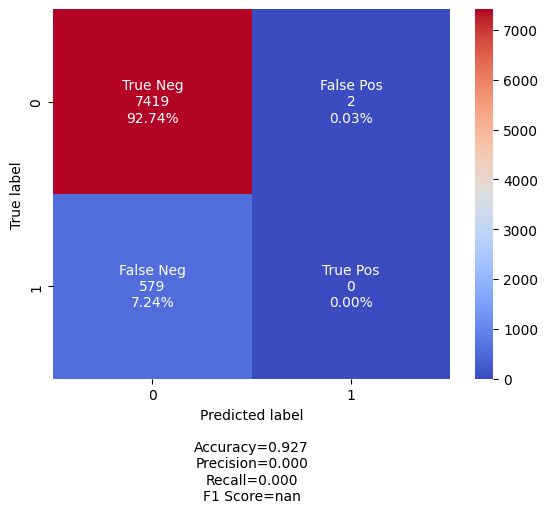

In [ ]:
# view confusion matrix
# the F1-score doesn't show but that's ok
cf_matrix_1=confusion_matrix(y_1_test,y_1_pred)
labels=['True Neg','False Pos','False Neg','True Pos']
make_confusion_matrix(cf=cf_matrix_1,
                      group_names=labels,
                      cmap='coolwarm')

In [ ]:
# view F1-score
creport=classification_report(y_test,y_1_pred)
print(creport)

              precision    recall  f1-score   support

          no       0.93      1.00      0.96      7421
         yes       0.00      0.00      0.00       579

    accuracy                           0.93      8000
   macro avg       0.46      0.50      0.48      8000
weighted avg       0.86      0.93      0.89      8000



Although we are able to get great accuracy for class 0 ('no'), we were not able to get a good accuracy for class 1 ('yes').

## Modeling: Layer 1

### Prepare Dataset for Modeling

Split data into training, validation, and testing sets:

In [547]:
data=pd.concat([X_1,y],axis=1)
data

,age,job,marital,education,default,balance,housing,loan,y
0,58,management,married,tertiary,no,2143,yes,no,0
1,44,technician,single,secondary,no,29,yes,no,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,0
3,47,blue-collar,married,unknown,no,1506,yes,no,0
4,33,unknown,single,unknown,no,1,no,no,0
...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,no,395,no,no,0
39996,30,management,single,tertiary,no,3340,no,no,1
39997,54,admin,divorced,secondary,no,200,no,no,1
39998,34,management,married,tertiary,no,1047,no,no,0


Create function to speed up preparing data for modeling going forward:

In [508]:
cat_cols = list(X_1.select_dtypes(include='object').columns)
num_cols = list(X_1.select_dtypes(exclude='object').columns)

num_cols

['age', 'balance']

In [509]:
cat_cols

['job', 'marital', 'education', 'default', 'housing', 'loan']

### Define and Run Functions for Modeling with a Pipeline

Define code for preprocessing, modeling, and evaluation:

In [536]:
classifier_map={
    'etc':ExtraTreeClassifier(random_state=seed),
    'xgb':XGBClassifier(random_state=seed),
    'dtc':DecisionTreeClassifier(random_state=seed),
    'rfc':RandomForestClassifier(random_state=seed),
    'lgb':LGBMClassifier(random_state=seed,verbose=-1),
    'lrx':LogisticRegression(random_state=seed),
    'sgd':SGDClassifier(random_state=seed),
    'lda':LinearDiscriminantAnalysis(),
    'rid':RidgeClassifier(random_state=seed),
    'gau':GaussianNB()
}

In [394]:
# Step 1: Splitting the data
def split_data(data, target_column_name, test_size=0.2, random_state=seed):
    X = data.drop(columns=[target_column_name])
    y = data[target_column_name]
    print('Data is split')
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Step 2: Create a function to build the pipeline
def create_pipeline(model, cat_cols, random_state=seed):
    # ColumnTransformer: Handle categorical and numerical preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ~X_train.columns.isin(cat_cols)),  # Scale numerical columns
            ('cat', OneHotEncoder(drop='first'), cat_cols)               # One-hot encode categorical columns
        ]
    )

    # RandomOverSampler for balancing the data
    oversampler = RandomOverSampler(sampling_strategy='minority',random_state=random_state)

    # Full pipeline with preprocessing, oversampling, and classifier
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('oversampler', oversampler),
        ('classifier', model)
    ])
    print('Pipeline is created')
    return pipeline

# Step 3: Evaluating the model with cross-validation
def evaluate_model(pipeline, X_train, y_train,random_state=seed):
    print('Evaluating model...')
    # kf = KFold(n_splits=5, shuffle=True, random_state=random_state)  # No stratification
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state) # With stratification
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='recall')
    print(f"Cross-validation recall scores: {scores}")
    print(f"Mean recall: {scores.mean():.4f}")

# Step 4: Final evaluation on the test set
def final_evaluation(pipeline, X_train, y_train, X_test, y_test):
    print('Fitting model...')
    pipeline.fit(X_train, y_train)  # Fit on the full training data

    print('Making predictions on training set...')
    y_train_pred = pipeline.predict(X_train)
    print("\nTraining Set Evaluation:")
    print(classification_report(y_train, y_train_pred))
    
    print('Making predictions on testing set...')
    y_test_pred = pipeline.predict(X_test)
    print("\nTest Set Evaluation:")
    print(classification_report(y_test, y_test_pred))

    # If the model supports feature importances, plot them
    if hasattr(pipeline.named_steps['classifier'], 'feature_importances_'):
        importances = pipeline.named_steps['classifier'].feature_importances_
        feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
        plot_feature_importances(importances, feature_names)

# Step 5: Plotting feature importances (if applicable)
def plot_feature_importances(importances, feature_names):
    feature_importances_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
    plt.title('Feature Importances')
    plt.show()

### Running various sampling techniques over our chosen classifiers

In [819]:
sampling_techniques = [
    RandomOverSampler(random_state=seed),
    SMOTETomek(random_state=seed),
    SMOTEN(random_state=seed),
    SMOTE(random_state=seed)
]

scaling_techniques=[
    StandardScaler(),
    MinMaxScaler(),
    None
]

X = data.drop(columns=[target_column_name])
y = data[target_column_name]
        
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed)

X_train_encoded=pd.get_dummies(X_train)
X_test_encoded=pd.get_dummies(X_test).reindex(columns=X_train_encoded.columns, fill_value=0)

In [625]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore',category=ConvergenceWarning)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

all_results={}

# Cross-validation setup
n_splits = 5
n_repeats = 3
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)

for scaler in scaling_techniques:
    if scaler:
        scaler_name = scaler.__class__.__name__
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_encoded), columns=X_train_encoded.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test_encoded), columns=X_test_encoded.columns)
    else:
        scaler_name = 'None'
        X_train_scaled = X_train_encoded.copy()
        X_test_scaled = X_test_encoded.copy()
    
    all_results[scaler_name] = {}
    print(f'Scaling technique: {scaler_name}')

    for technique in sampling_techniques:
        X_train_res, y_train_res = technique.fit_resample(X_train_scaled, y_train)
        technique_name = technique.__class__.__name__
        all_results[scaler_name][technique_name] = {}

        print(f'Sampling technique: {technique_name}')

        # Train and evaluate models with cross-validation
        for model_name, model in classifier_map.items():
            print(f'Running model: {model_name}')

            model.fit(X_train_res, y_train_res)
            y_pred = model.predict(X_test_scaled)

            # Create and store the classification report
            class_report = classification_report(y_test, y_pred, output_dict=True)
            
            # Use cross-validation to evaluate multiple metrics
            scores = cross_validate(
                model, X_train_res, y_train_res, 
                cv=cv, scoring=scoring, return_train_score=True
            )

            # Store all metrics for each model
            all_results[scaler_name][technique_name][model_name] = {
                'mean_accuracy': scores['test_accuracy'].mean(),
                'std_accuracy': scores['test_accuracy'].std(),
                'mean_precision': scores['test_precision'].mean(),
                'std_precision': scores['test_precision'].std(),
                'mean_recall': scores['test_recall'].mean(),
                'std_recall': scores['test_recall'].std(),
                'mean_f1': scores['test_f1'].mean(),
                'std_f1': scores['test_f1'].std(),
                'classification_report':class_report,
                'all_scores': scores  # Store the full cross-validation output
            }

            print(f"Model: {model_name} | Accuracy: {scores['test_accuracy'].mean():.4f}, "
                  f"Precision: {scores['test_precision'].mean():.4f}, "
                  f"Recall: {scores['test_recall'].mean():.4f}, "
                  f"F1: {scores['test_f1'].mean():.4f}")

print('Done!')

Scaling technique: StandardScaler
Sampling technique: RandomOverSampler
Running model: etc
Model: etc | Accuracy: 0.9542, Precision: 0.9165, Recall: 0.9994, F1: 0.9561
Running model: xgb
Model: xgb | Accuracy: 0.7969, Precision: 0.7767, Recall: 0.8335, F1: 0.8041
Running model: dtc
Model: dtc | Accuracy: 0.9535, Precision: 0.9154, Recall: 0.9994, F1: 0.9555
Running model: rfc
Model: rfc | Accuracy: 0.9647, Precision: 0.9345, Recall: 0.9994, F1: 0.9659
Running model: lgb
Model: lgb | Accuracy: 0.7279, Precision: 0.7231, Recall: 0.7388, F1: 0.7308
Running model: lrx
Model: lrx | Accuracy: 0.5806, Precision: 0.5861, Recall: 0.5486, F1: 0.5667
Running model: sgd
Model: sgd | Accuracy: 0.5657, Precision: 0.5733, Recall: 0.5151, F1: 0.5417
Running model: lda
Model: lda | Accuracy: 0.5802, Precision: 0.5860, Recall: 0.5469, F1: 0.5657
Running model: rid
Model: rid | Accuracy: 0.5802, Precision: 0.5860, Recall: 0.5469, F1: 0.5657
Running model: gau
Model: gau | Accuracy: 0.5706, Precision: 0.5

/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Model: lrx | Accuracy: 0.7575, Precision: 0.8094, Recall: 0.6737, F1: 0.7353
Running model: sgd
Model: sgd | Accuracy: 0.7544, Precision: 0.8343, Recall: 0.6396, F1: 0.7221
Running model: lda
Model: lda | Accuracy: 0.7547, Precision: 0.8243, Recall: 0.6474, F1: 0.7252
Running model: rid
Model: rid | Accuracy: 0.7546, Precision: 0.8243, Recall: 0.6473, F1: 0.7251
Running model: gau
Model: gau | Accuracy: 0.6205, Precision: 0.5720, Recall: 0.9568, F1: 0.7160
Sampling technique: SMOTE
Running model: etc
Model: etc | Accuracy: 0.7933, Precision: 0.7957, Recall: 0.7893, F1: 0.7925
Running model: xgb
Model: xgb | Accuracy: 0.8394, Precision: 0.8936, Recall: 0.7706, F1: 0.8275
Running model: dtc
Model: dtc | Accuracy: 0.8420, Precision: 0.8405, Recall: 0.8442, F1: 0.8424
Running model: rfc
Model: rfc | Accuracy: 0.8349, Precision: 0.8371, Recall: 0.8316, F1: 0.8344
Running model: lgb
Model: lgb | Accuracy: 0.8665, Precision: 0.9383, Recall: 0.7847, F1: 0.8546
Running model: lrx
Model: lrx | A

/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Model: lrx | Accuracy: 0.5766, Precision: 0.5814, Recall: 0.5477, F1: 0.5640
Running model: sgd
Model: sgd | Accuracy: 0.5099, Precision: 0.4819, Recall: 0.3155, F1: 0.3162
Running model: lda
Model: lda | Accuracy: 0.5802, Precision: 0.5860, Recall: 0.5469, F1: 0.5657
Running model: rid
Model: rid | Accuracy: 0.5803, Precision: 0.5860, Recall: 0.5469, F1: 0.5658
Running model: gau
Model: gau | Accuracy: 0.5711, Precision: 0.5714, Recall: 0.5691, F1: 0.5702
Sampling technique: SMOTETomek
Running model: etc
Model: etc | Accuracy: 0.9352, Precision: 0.9332, Recall: 0.9375, F1: 0.9354
Running model: xgb
Model: xgb | Accuracy: 0.9516, Precision: 0.9943, Recall: 0.9085, F1: 0.9495
Running model: dtc
Model: dtc | Accuracy: 0.9357, Precision: 0.9304, Recall: 0.9418, F1: 0.9361
Running model: rfc
Model: rfc | Accuracy: 0.9558, Precision: 0.9727, Recall: 0.9378, F1: 0.9549
Running model: lgb
Model: lgb | Accuracy: 0.9502, Precision: 0.9968, Recall: 0.9032, F1: 0.9477
Running model: lrx


/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Model: lrx | Accuracy: 0.9133, Precision: 0.9626, Recall: 0.8600, F1: 0.9084
Running model: sgd
Model: sgd | Accuracy: 0.6237, Precision: 0.6098, Recall: 0.8142, F1: 0.6726
Running model: lda


/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Model: lda | Accuracy: 0.9064, Precision: 1.0000, Recall: 0.8128, F1: 0.8967
Running model: rid


/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Model: rid | Accuracy: 0.9065, Precision: 1.0000, Recall: 0.8131, F1: 0.8969
Running model: gau
Model: gau | Accuracy: 0.7700, Precision: 0.7147, Recall: 0.8989, F1: 0.7962
Sampling technique: SMOTEN
Running model: etc
Model: etc | Accuracy: 0.9256, Precision: 0.9159, Recall: 0.9373, F1: 0.9265
Running model: xgb
Model: xgb | Accuracy: 0.9106, Precision: 0.9111, Recall: 0.9100, F1: 0.9105
Running model: dtc
Model: dtc | Accuracy: 0.9225, Precision: 0.9086, Recall: 0.9396, F1: 0.9238
Running model: rfc
Model: rfc | Accuracy: 0.9453, Precision: 0.9554, Recall: 0.9343, F1: 0.9447
Running model: lgb
Model: lgb | Accuracy: 0.8944, Precision: 0.8936, Recall: 0.8954, F1: 0.8945
Running model: lrx


/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Model: lrx | Accuracy: 0.7093, Precision: 0.7148, Recall: 0.6975, F1: 0.7058
Running model: sgd
Model: sgd | Accuracy: 0.5856, Precision: 0.6341, Recall: 0.5418, F1: 0.5535
Running model: lda
Model: lda | Accuracy: 0.7547, Precision: 0.8243, Recall: 0.6474, F1: 0.7252
Running model: rid
Model: rid | Accuracy: 0.7546, Precision: 0.8240, Recall: 0.6477, F1: 0.7252
Running model: gau
Model: gau | Accuracy: 0.6363, Precision: 0.5836, Recall: 0.9512, F1: 0.7234
Sampling technique: SMOTE
Running model: etc
Model: etc | Accuracy: 0.9277, Precision: 0.9259, Recall: 0.9298, F1: 0.9278
Running model: xgb
Model: xgb | Accuracy: 0.9469, Precision: 0.9947, Recall: 0.8986, F1: 0.9442
Running model: dtc
Model: dtc | Accuracy: 0.9272, Precision: 0.9222, Recall: 0.9331, F1: 0.9276
Running model: rfc
Model: rfc | Accuracy: 0.9492, Precision: 0.9681, Recall: 0.9290, F1: 0.9481
Running model: lgb
Model: lgb | Accuracy: 0.9463, Precision: 0.9969, Recall: 0.8954, F1: 0.9434
Running model: lrx


/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Model: lrx | Accuracy: 0.9122, Precision: 0.9632, Recall: 0.8572, F1: 0.9071
Running model: sgd
Model: sgd | Accuracy: 0.5634, Precision: 0.6185, Recall: 0.4838, F1: 0.4540
Running model: lda


/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Model: lda | Accuracy: 0.9035, Precision: 1.0000, Recall: 0.8070, F1: 0.8932
Running model: rid


/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Model: rid | Accuracy: 0.9036, Precision: 1.0000, Recall: 0.8071, F1: 0.8933
Running model: gau
Model: gau | Accuracy: 0.7656, Precision: 0.7104, Recall: 0.8970, F1: 0.7928
Done!


#### Save results

In [626]:
fileDaterSaver(
    location='../joblib/',
    filetype='json',
    object_=all_results,
    extra='2_l1_survey')

current_datetime: 2024-10-30 11:09:33.127901
../joblib/2_l1_survey_2024-10-30_11-09-33.json
Successfully saved object_ to ../joblib/2_l1_survey_2024-10-30_11-09-33.json


#### Extract best recall

In [698]:
file_name='../joblib/2_l1_survey_2024-10-30_11-09-33.json'

# extract best params file
with open(file_name,'r') as file:
    all_results=json.load(file)

In [699]:
# Initialize variables to track the best recall and corresponding model/technique
best_recall = 0
best_model_info = None

# Iterate through all sampling techniques and models
for scaler_name,techniques in all_results.items():
    for technique_name, models in techniques.items():
        for model_name, metrics in models.items():
            # Extract the recall score for the minority class (class '1')
            recall = metrics['classification_report']['1']['recall']

            # Check if this recall is the highest so far
            if recall > best_recall:
                best_recall = recall
                best_model_info = (scaler_name,technique_name, model_name)

# Print the best recall and corresponding technique and model for class 1 (minority class)
if best_model_info:
    print(f"Best Recall: {best_recall}")
    print(f'Scaler: {best_model_info[0]}')
    print(f"Technique: {best_model_info[1]}")
    print(f'Model: {best_model_info[2]}')

Best Recall: 0.8737201365187713
Scaler: None
Technique: SMOTE
Model: sgd


That recall is great! Let's see the classification report and confusion matrix for a rerun of the best techniques:

#### Run new classifier on best techniques for high recall

              precision    recall  f1-score   support

           0       0.95      0.19      0.31      7414
           1       0.08      0.87      0.14       586

    accuracy                           0.24      8000
   macro avg       0.51      0.53      0.23      8000
weighted avg       0.89      0.24      0.30      8000



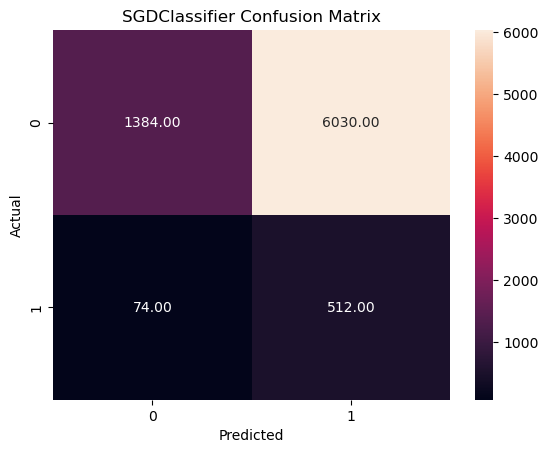

In [789]:
# SMOTE only on train set
smote=SMOTE(random_state=seed)
X_train_res, y_train_res = smote.fit_resample(X_train_encoded, y_train)

sgd=classifier_map['sgd']
sgd.fit(X_train_res,y_train_res)
y_pred=sgd.predict(X_test_encoded)
print(classification_report(y_test,y_pred))

sns.heatmap(data=confusion_matrix(y_test,y_pred),annot=True,fmt='.2f')
plt.title('SGDClassifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

With SGDClassifier shown to be the most performant model for Class 1 recall, we will now use an Optuna search to find the best hyperparameters.

##### Optuna search to find best parameters with `SGDClassifier`

In [675]:
# prepare data for Optuna
X = data.drop(columns=[target_column_name])
y = data[target_column_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# set up OneHotEncoder
categorical_features = X.select_dtypes(include=['object', 'category']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# fit the transformer on the training data and transform both train and test
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# apply SMOTE only on the training set
smote = SMOTE(random_state=seed)
X_train_res, y_train_res = smote.fit_resample(X_train_encoded, y_train)

In [676]:
n_trials=100

In [677]:
# write function to help speed up training process
def fit_and_score(train_idx, valid_idx, classifier, X, y, seed):
    # Split the data
    X_fold_train, X_fold_valid = X[train_idx], X[valid_idx]
    y_fold_train, y_fold_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # Oversample the training data only
    res = SMOTE(random_state=seed)
    X_fold_train_res, y_fold_train_res = res.fit_resample(X_fold_train, y_fold_train)

    # Fit the model on the resampled data
    classifier.fit(X_fold_train_res, y_fold_train_res)

    # Predict on the validation fold
    y_pred = classifier.predict(X_fold_valid)

    # Calculate recall for this fold and return it
    return recall_score(y_fold_valid, y_pred)

In [678]:
# Start tracking time
start_time = time.time()

def objective(trial):
    # Define the classifier with conditional parameters
    penalty=trial.suggest_categorical('penalty',['l2',
                                                 'l1',
                                                 'elasticnet',
                                                 None])
    if penalty=='elasticnet':
        l1_ratio=trial.suggest_float('l1_ratio',0,1)
    else:
        l1_ratio=0.15
    loss=trial.suggest_categorical('loss',['hinge',
                                       'log_loss',
                                       'modified_huber',
                                       'squared_hinge',
                                       'perceptron',
                                       'squared_error',
                                       'huber',
                                       'episolon_insensitive',
                                       'squared_epsilon_insensitive'])
    if loss in ['epsilon_insensitive', 'squared_epsilon_insensitive','huber']:
        epsilon = trial.suggest_float('epsilon', 0.0, 1.0)
    else:
        epsilon=0.1
    tol_choice=trial.suggest_categorical('tol_choice',['float_',None])
    if tol_choice=='float_':
        tol=trial.suggest_float('tol',1E-4,1E2)
    else:
        tol=None
    learning_rate=trial.suggest_categorical('learning_rate',['constant',
                                                        'optimal',
                                                        'invscaling',
                                                        'adaptive'])
    if learning_rate in ['constant','invscaling','adaptive']:
        eta0=trial.suggest_float('eta0',1E-3,1E0)
        if learning_rate=='invscaling':
            power_t=trial.suggest_float('power_t',1E-3,1E3)
        else:
            power_t=0.5
    else:
        eta0=0.0
        power_t=0.5
    early_stopping=trial.suggest_categorical('early_stopping',[True,False])
    if early_stopping==True:
        validation_fraction=trial.suggest_float('validation_fraction',0.05,0.4)
    else:
        validation_fraction=0.1
        
    classifier = SGDClassifier(
        penalty=penalty,
        alpha=trial.suggest_float('alpha',1E-8,1E3,log=True),
        l1_ratio=l1_ratio,
        fit_intercept=trial.suggest_categorical('fit_intercept',[True,False]),
        max_iter=trial.suggest_int('max_iter',100,int(1E4)),
        tol=tol,
        verbose=0,
        epsilon=epsilon,
        n_jobs=-1,
        random_state=seed,
        learning_rate=learning_rate,
        eta0=eta0,
        power_t=power_t,
        early_stopping=early_stopping,
        validation_fraction=validation_fraction,
        class_weight='balanced',
        n_iter_no_change=5
    )

    # Define Stratified K-Fold cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    # Parallel cross-validation
    recall_scores = Parallel(n_jobs=-1)(
        delayed(fit_and_score)(train_idx, valid_idx, classifier, X_train_encoded, y_train, seed)
        for train_idx, valid_idx in cv.split(X_train_encoded, y_train)
    )

    # Return the mean recall across all folds
    return np.mean(recall_scores)

# Run the Optuna study
sgd = optuna.create_study(direction='maximize')
sgd.optimize(objective, n_trials=n_trials)

# Track time
end_time = time.time()
elapsed_time = end_time - start_time

# Store results and time tracking
times['sgd'] = {
    'start_time_sgd': start_time,
    'end_time_sgd': end_time,
    'elapsed_time_sgd': elapsed_time
}
results['sgd'] = sgd.best_params

print('Done!')

[I 2024-10-30 22:19:50,799] A new study created in memory with name: no-name-334f8dff-d051-4b97-b1e0-ab603f203eee
[I 2024-10-30 22:20:30,612] Trial 0 finished with value: 0.3861471861471862 and parameters: {'penalty': None, 'loss': 'perceptron', 'tol_choice': None, 'learning_rate': 'optimal', 'early_stopping': False, 'alpha': 6.760861599582108e-06, 'fit_intercept': False, 'max_iter': 8505}. Best is trial 0 with value: 0.3861471861471862.
[I 2024-10-30 22:20:31,847] Trial 1 finished with value: 0.5883116883116883 and parameters: {'penalty': 'l2', 'loss': 'hinge', 'tol_choice': 'float_', 'tol': 90.6752638649478, 'learning_rate': 'adaptive', 'eta0': 0.5394011939106076, 'early_stopping': False, 'alpha': 0.004109302162613352, 'fit_intercept': False, 'max_iter': 2983}. Best is trial 1 with value: 0.5883116883116883.
[I 2024-10-30 22:20:32,724] Trial 2 finished with value: 0.9242424242424242 and parameters: {'penalty': None, 'loss': 'squared_epsilon_insensitive', 'epsilon': 0.4425446611268078

Done!


##### Save results and extract them

In [679]:
fileDaterSaver(
    location='../joblib/',
    filetype='json',
    object_=results,
    extra='2_l1_sgd')

fileDaterSaver(
    location='../joblib/',
    filetype='json',
    object_=times,
    extra='2_l1_sgd_times')

current_datetime: 2024-10-30 22:46:27.720970
../joblib/2_l1_sgd_2024-10-30_22-46-27.json
Successfully saved object_ to ../joblib/2_l1_sgd_2024-10-30_22-46-27.json
current_datetime: 2024-10-30 22:46:27.723219
../joblib/2_l1_sgd_times_2024-10-30_22-46-27.json
Successfully saved object_ to ../joblib/2_l1_sgd_times_2024-10-30_22-46-27.json


In [748]:
file_name='../joblib/2_l1_sgd_2024-10-30_22-46-27.json'

# extract best params file
with open(file_name,'r') as file:
    best_params_sgd=json.load(file)
    
best_params_sgd=best_params_sgd['sgd']
del best_params_sgd['tol_choice']
best_params_sgd

{'penalty': 'elasticnet',
 'l1_ratio': 0.9665372247163372,
 'loss': 'modified_huber',
 'tol': 75.52719927740569,
 'learning_rate': 'invscaling',
 'eta0': 0.7274942852090539,
 'power_t': 647.2058587404654,
 'early_stopping': True,
 'validation_fraction': 0.3765902841689254,
 'alpha': 7.181611953044439e-07,
 'fit_intercept': False,
 'max_iter': 1344}

```python
[I 2024-10-30 22:20:34,397] Trial 7 finished with value: 0.9463203463203463 and parameters: {'penalty': 'elasticnet', 'l1_ratio': 0.9665372247163372, 'loss': 'modified_huber', 'tol_choice': 'float_', 'tol': 75.52719927740569, 'learning_rate': 'invscaling', 'eta0': 0.7274942852090539, 'power_t': 647.2058587404654, 'early_stopping': True, 'validation_fraction': 0.3765902841689254, 'alpha': 7.181611953044439e-07, 'fit_intercept': False, 'max_iter': 1344}. Best is trial 7 with value: 0.9463203463203463.
```

```Python
[I 2024-10-30 22:15:29,750] Trial 0 finished with value: 0.9878787878787879 and parameters: {'penalty': 'elasticnet', 'l1_ratio': 0.6792821002751159, 'loss': 'squared_hinge', 'tol_choice': 'float_', 'tol': 77.67102207046132, 'learning_rate': 'optimal', 'early_stopping': True, 'validation_fraction': 0.3515381185934471, 'alpha': 85.71089401293582, 'fit_intercept': True, 'max_iter': 4953}. Best is trial 0 with value: 0.9878787878787879.
```

In [682]:
other_params={'penalty': 'elasticnet', 'l1_ratio': 0.6792821002751159, 'loss': 'squared_hinge', 'tol_choice': 'float_', 'tol': 77.67102207046132, 'learning_rate': 'optimal', 'early_stopping': True, 'validation_fraction': 0.3515381185934471, 'alpha': 85.71089401293582, 'fit_intercept': True, 'max_iter': 4953}

##### Run `best_params` on `SGDClassifier`

              precision    recall  f1-score   support

           0       0.95      0.10      0.17      7414
           1       0.08      0.94      0.14       586

    accuracy                           0.16      8000
   macro avg       0.51      0.52      0.16      8000
weighted avg       0.89      0.16      0.17      8000



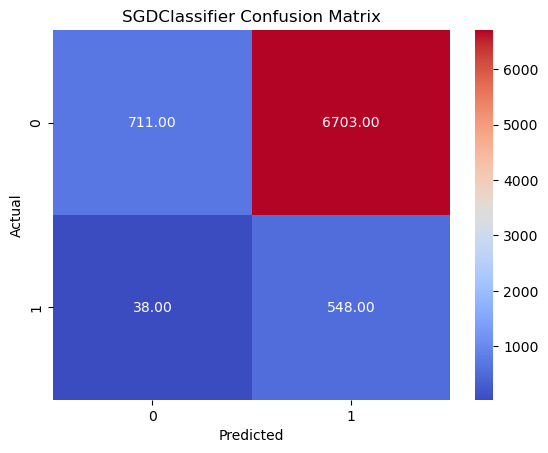

In [919]:
# classification report and confusion matrix for high-recall classifier
sgd=SGDClassifier(**best_params_sgd)

smote=SMOTE(random_state=seed)
X_train_res,y_train_res=smote.fit_resample(X_train_encoded,y_train)

sgd.fit(X_train_res,y_train_res)

y_pred=sgd.predict(X_test_encoded)

print(classification_report(y_test,y_pred))

sns.heatmap(data=confusion_matrix(y_test,y_pred),annot=True,fmt='.2f',cmap='coolwarm')
plt.title('SGDClassifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##### Interpreting the results

* When precision for class 0 is 95%, that means when the model predicts a customer as a non-subscriber, it is correct 95% of the time.
* A precision of 8% for class 1 indicates that the model is correctly predicting a customer as a subscriber 8% of the time. There are many false positives.
* The recall for class 0 is 10%, which means that the model is only identifying 10% of the non-subscribers correctly.
* A very high recall of 94% shows that the model identifies almost all of the actual subscribers correctly.

Take-home message: this model is really good at predicting subscribers.

In [776]:
print(f"Average call time: {(df['duration'].mean()/60):.2f} minutes")

Average call time: 4.25 minutes


Without the model, the company would be calling all `8000` customers, which would take about:

In [785]:
print(f"{(4.25*8000)/60:.2f} hours")

566.67 hours


In [803]:
tp=548
fp=6703
tot_call=tp+fp
print('tot_call',tot_call)
mean_call_minutes=df['duration'].mean()/60
print('mean_call_minutes',mean_call_minutes)
tot_call_min=tot_call*mean_call_minutes
print('tot_call_min',tot_call_min)
tot_customers=8000
without_model=tot_customers*mean_call_minutes
print('without_model',without_model)
saved_time=(without_model-tot_call_min)/60
print('saved_time',saved_time,'hours')

tot_call 7251
mean_call_minutes 4.247071666666667
tot_call_min 30795.516655
without_model 33976.573333333334
saved_time 53.01761130555557 hours


With the model, the company is saving time.
* The model flags 548 customers as likely subscribers (these are the true positives)
* The company will call these customers along with 6,703 non-subscribers (false positives)
* Therefore, the total number of calls the company will make with the model is:  
$548+6703=7251\text{ calls}$
* Total time with the model:  
$7251\text{ calls} \times 4.25\text{ minutes} = 30,816.75\text{ minutes}$
* Time saved:  
$33,976.57\text{ minutes (without model)} - 30,795.52\text{ minutes (with model)}= 3,183.75\text { minutes saved, or}$  
<mark>$53.02\text{ hours}$</mark>

              precision    recall  f1-score   support

           0       0.95      0.19      0.31      7414
           1       0.08      0.87      0.14       586

    accuracy                           0.24      8000
   macro avg       0.51      0.53      0.23      8000
weighted avg       0.89      0.24      0.30      8000



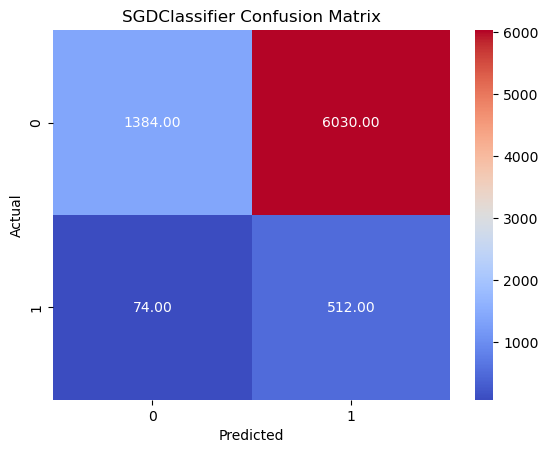

In [920]:
# SMOTE only on train set
smote=SMOTE(random_state=seed)
X_train_res, y_train_res = smote.fit_resample(X_train_encoded, y_train)

sgd=classifier_map['sgd']
sgd.fit(X_train_res,y_train_res)
y_pred=sgd.predict(X_test_encoded)
print(classification_report(y_test,y_pred))

sns.heatmap(data=confusion_matrix(y_test,y_pred),annot=True,fmt='.2f',cmap='coolwarm')
plt.title('SGDClassifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [805]:
tp=512
fp=6030
tot_call=tp+fp
print('tot_call',tot_call)
mean_call_minutes=df['duration'].mean()/60
print('mean_call_minutes',mean_call_minutes)
tot_call_min=tot_call*mean_call_minutes
print('tot_call_min',tot_call_min)
tot_customers=8000
without_model=tot_customers*mean_call_minutes
print('without_model',without_model)
saved_time=(without_model-tot_call_min)/60
print('saved_time',saved_time,'hours')

tot_call 6542
mean_call_minutes 4.247071666666667
tot_call_min 27784.342843333336
without_model 33976.573333333334
saved_time 103.20384149999997 hours


Interestingly, if we use the untuned (though with ideal techniques) model, we save the company about double the time!

Although saving a company 50 or 100 hours is good, but I'm wondering if we can do better. What about the weighted F1 score? It is a metric that is the harmonic mean of the recall and precision and also tries to account for the class distribution.

#### Extract best F1 Score (weighted or macro)

In [810]:
file_name='../joblib/2_l1_survey_2024-10-30_11-09-33.json'

# extract best params file
with open(file_name,'r') as file:
    all_results=json.load(file)

In [827]:
# initialize variables to track the best metric and corresponding model/technique
best_f1=0
best_model_info=None

# iterate through all sampling techniques and models
for scaler_name,techniques in all_results.items():
    for technique_name,models in techniques.items():
        for model_name,metrics in models.items():
            # Extract the metric score for the minority class (class '1')
            f1=metrics['classification_report']['macro avg']['f1-score']

            # Check if this recall is the highest so far
            if f1>best_f1:
                best_f1=f1
                best_model_info=(scaler_name,technique_name, model_name)

# print the best metric and corresponding technique and model for class 1 (minority class)
if best_model_info:
    print(f"Best Weighted F1: {best_f1}")
    print(f'Scaler: {best_model_info[0]}')
    print(f"Technique: {best_model_info[1]}")
    print(f'Model: {best_model_info[2]}')

Best Weighted F1: 0.5570330897748716
Scaler: MinMaxScaler
Technique: SMOTE
Model: lgb


#### Run new classifier on best techniques for F1 score

running resampler
(59380, 27)
(59380,)
fitting classifier
predicting y_pred
              precision    recall  f1-score   support

           0       0.94      0.57      0.71      7414
           1       0.09      0.56      0.16       586

    accuracy                           0.57      8000
   macro avg       0.52      0.57      0.43      8000
weighted avg       0.88      0.57      0.67      8000



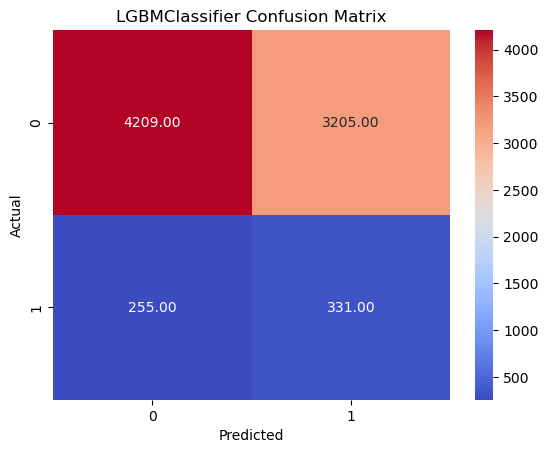

In [921]:
# run scaler before resampling
scaler=MinMaxScaler()

X_train_scaled=scaler.fit_transform(X_train_encoded)
X_test_scaled=scaler.transform(X_test_encoded)

# resample only on train set
res=SMOTE(random_state=seed)
print('running resampler')
X_train_res, y_train_res = res.fit_resample(X_train_scaled, y_train)
print(X_train_res.shape)
print(y_train_res.shape)

lgb=classifier_map['lgb']
print('fitting classifier')
lgb.fit(X_train_res,y_train_res)
print('predicting y_pred')
y_pred=lgb.predict(X_test_encoded)
print(classification_report(y_test,y_pred))

sns.heatmap(data=confusion_matrix(y_test,y_pred),annot=True,fmt='.2f',cmap='coolwarm')
plt.title('LGBMClassifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

0.05
              precision    recall  f1-score   support

           0       0.94      0.27      0.42      7414
           1       0.08      0.77      0.14       586

    accuracy                           0.31      8000
   macro avg       0.51      0.52      0.28      8000
weighted avg       0.87      0.31      0.40      8000



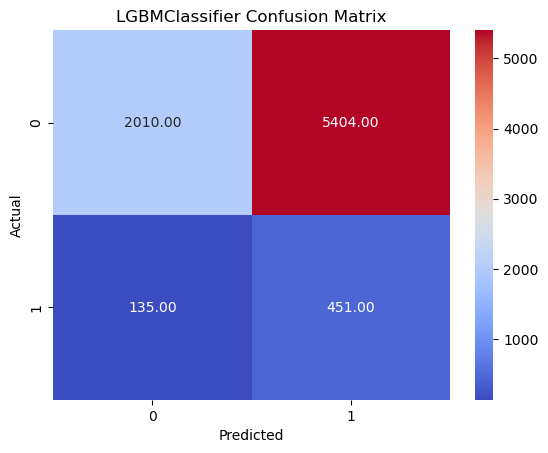

In [922]:
# Custom F2 scorer
f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')

# Resampling technique (e.g., SMOTETomek)
smotetomek = SMOTETomek(random_state=seed)
X_train_res, y_train_res = smotetomek.fit_resample(X_train_scaled, y_train)

# Initialize model with balanced class weights
model = RandomForestClassifier(class_weight='balanced', random_state=seed)

# Train model
model.fit(X_train_res, y_train_res)

# Predict probabilities on test set for threshold adjustment
y_probs = model.predict_proba(X_test_scaled)[:, 1]

# Adjust threshold to optimize recall for class 1 while retaining reasonable recall for class 0
optimal_threshold = 0.05
print(optimal_threshold)

y_pred = (y_probs >= optimal_threshold).astype(int)

# Evaluate the recall scores
print(classification_report(y_test, y_pred))

sns.heatmap(data=confusion_matrix(y_test,y_pred),annot=True,fmt='.2f',cmap='coolwarm')
plt.title('LGBMClassifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

0.005
              precision    recall  f1-score   support

           0       0.95      0.07      0.13      7414
           1       0.08      0.96      0.14       586

    accuracy                           0.14      8000
   macro avg       0.52      0.51      0.14      8000
weighted avg       0.89      0.14      0.13      8000



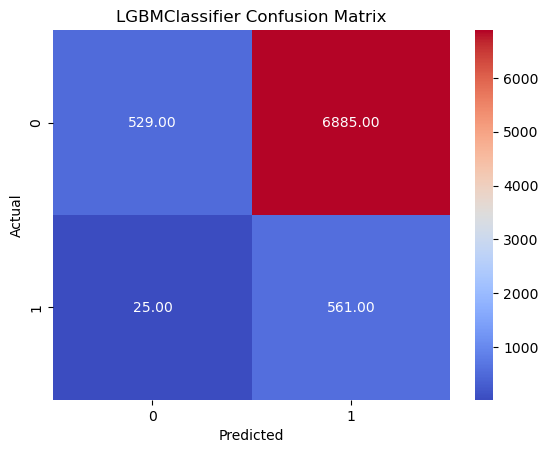

In [923]:
# Resampling technique (e.g., SMOTETomek)
smotetomek = SMOTETomek(random_state=seed)
X_train_res, y_train_res = smotetomek.fit_resample(X_train_scaled, y_train)

# Initialize model with balanced class weights
model = RandomForestClassifier(class_weight='balanced', random_state=seed)

# Train model
model.fit(X_train_res, y_train_res)

# Predict probabilities on test set for threshold adjustment
y_probs = model.predict_proba(X_test_scaled)[:, 1]

# Adjust threshold to optimize recall for class 1 while retaining reasonable recall for class 0
optimal_threshold = 0.005
print(optimal_threshold)

y_pred = (y_probs >= optimal_threshold).astype(int)

# Evaluate the recall scores
print(classification_report(y_test, y_pred))

sns.heatmap(data=confusion_matrix(y_test,y_pred),annot=True,fmt='.2f',cmap='coolwarm')
plt.title('LGBMClassifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

This is the best recall for class 1 result we got so far, with only 25 false negatives. That being said, we're not saving the company a lot of time.

#### Experiment on Threshold Values for Probabilities

In [928]:
# scaler
scaler=MinMaxScaler()

X_train_scaled=scaler.fit_transform(X_train_encoded)
X_test_scaled=scaler.transform(X_test_encoded)

# resampling technique
res=SMOTE(random_state=seed)
X_train_res,y_train_res=res.fit_resample(X_train_scaled,y_train)

# initialize model with balanced class weights
model=LGBMClassifier(class_weight='balanced', random_state=seed)

# custom F2 scorer, cross_validation
f2_scorer=make_scorer(fbeta_score, beta=2, average='weighted')
f2_scores=cross_val_score(model,X_train_res,y_train_res,scoring=f2_scorer,cv=5)

# train model
model.fit(X_train_res,y_train_res)

# predict probabilities on test set for threshold adjustment
y_probs=model.predict_proba(X_test_scaled)[:,1]

rec_c1_list=[] # recall scores for class 1
rec_c0_list=[] # recall scores for class 0
class_idx=1 # we're focusing on class 1 for tp and fp
post_c1_list=[] # true positive class 1
posf_c1_list=[] # false positive class 1

optimal_threshold=np.logspace(-3,np.log10(0.9),num=50).tolist()
for threshold in optimal_threshold:
    y_pred=(y_probs >= threshold).astype(int)
    
    # extract recall scores
    report=classification_report(y_test,
                                 y_pred,
                                 output_dict=True,
                                 zero_division=0) # because of warnings
    rec_c1=report['1']['recall']
    rec_c0=report['0']['recall']
    rec_c1_list.append(rec_c1)
    rec_c0_list.append(rec_c0)
    
    # extract true positives and false positives
    cm=confusion_matrix(y_test,y_pred)
    # True Positives (TP) for class 1
    post_c1=cm[class_idx, class_idx]
    posf_c1=cm[:,class_idx].sum()-post_c1
    post_c1_list.append(post_c1)
    posf_c1_list.append(posf_c1)

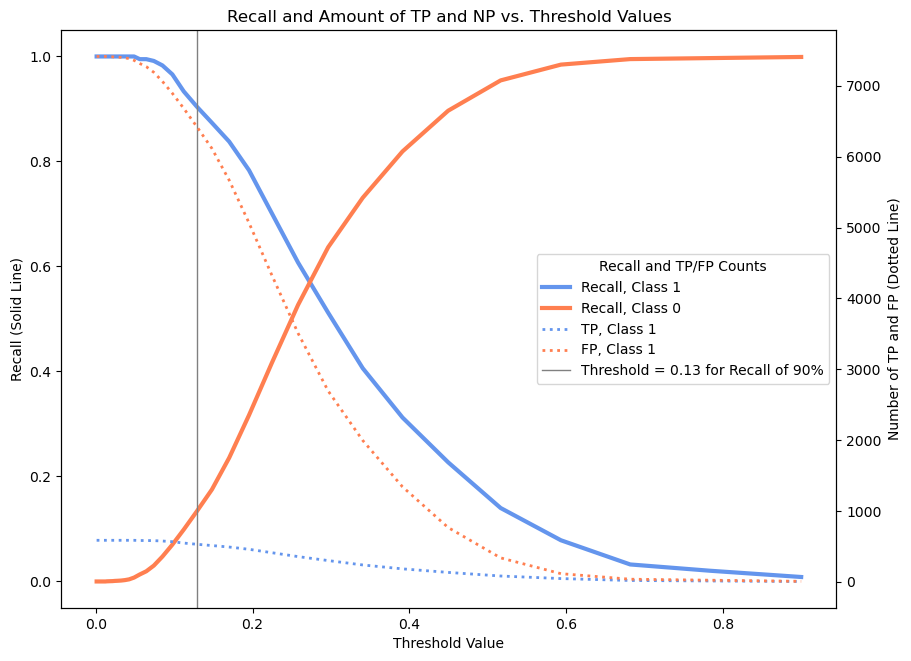

In [929]:
### make figure showing results of threshold experimentation on recall and TP/FP
fig,ax1=plt.subplots(figsize=(10,7.5))
ax1.set_title('Recall and Amount of TP and NP vs. Threshold Values')

# left side of figure showing recall scores
ax1.plot(optimal_threshold,rec_c1_list,color='cornflowerblue',label='Recall, Class 1',linewidth=3)
ax1.plot(optimal_threshold,rec_c0_list,color='coral',label='Recall, Class 0',linewidth=3)
ax1.set_ylabel('Recall (Solid Line)')
ax1.set_xlabel('Threshold Value')

# right side of figure showing TP/FP amounts
ax2=ax1.twinx()
ax2.plot(optimal_threshold,post_c1_list,color='cornflowerblue',label='TP, Class 1',linestyle=':',linewidth=2)
ax2.plot(optimal_threshold,posf_c1_list,color='coral',label='FP, Class 1',linestyle=':',linewidth=2)
ax2.set_ylabel('Number of TP and FP (Dotted Line)')

## other enhancements
# line where recall for class 1 is closest to 90%
target_recall=0.9
closest_index=np.argmin(np.abs(np.array(rec_c1_list)-target_recall))
closest_threshold=optimal_threshold[closest_index]
vertical_line=ax1.axvline(x=closest_threshold,color='grey',linestyle='-',linewidth=1)

# joint legend
lines,labels=ax1.get_legend_handles_labels()
lines2,labels2=ax2.get_legend_handles_labels()
all_lines=lines+lines2+[vertical_line]
all_labels=labels+labels2+[f'Threshold = {closest_threshold:.2f} for Recall of 90%']
ax1.legend(all_lines,all_labels,loc='center right',title="Recall and TP/FP Counts")

plt.savefig('../figs/2_l1_RecallTPNPThreshold_smotetomek.png')
plt.savefig('../figs/2_l1_RecallTPNPThreshold_smotetomek.pdf')
plt.show()

In [933]:
# closest_threshold
# 0.11217150777598589 for SMOTETomek

In [934]:
# closest_threshold
# 0.12887634804436812 for SMOTE

I called out where the recall is closest to 90%. Let's try to run a model with our optimal techniques to observe the classification report and confusion matrix at this threshold value of $0.11$.

##### SMOTE-Tomek


Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.94      0.12      0.21      7414
           1       0.08      0.91      0.14       586

    accuracy                           0.18      8000
   macro avg       0.51      0.51      0.18      8000
weighted avg       0.88      0.18      0.21      8000



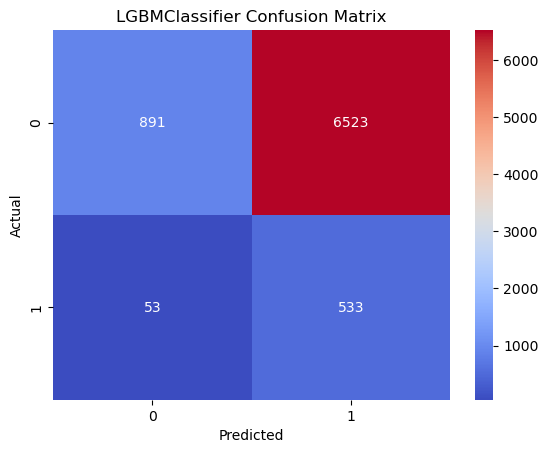

In [935]:
# scaler
scaler=MinMaxScaler()
X_train_scaled=scaler.fit_transform(X_train_encoded)
X_test_scaled=scaler.transform(X_test_encoded)

# resampling technique
res=SMOTETomek(random_state=seed)
X_train_res,y_train_res=res.fit_resample(X_train_scaled, y_train)

# initialize model with balanced class weights
model = LGBMClassifier(class_weight='balanced', random_state=seed)

# define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# get cross-validated probabilities on the resampled training set
y_probs_cv = cross_val_predict(model, X_train_res, y_train_res, cv=cv, method='predict_proba')[:, 1]

# select threshold
optimal_threshold = 0.11217150777598589

# Refit the model on the entire resampled training set
model.fit(X_train_res, y_train_res)

# Predict probabilities on the test set and apply the optimal threshold
y_probs_test = model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_probs_test >= optimal_threshold).astype(int)

# Evaluate the recall scores
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))

# Confusion matrix
sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True, fmt='', cmap="coolwarm")
plt.title('LGBMClassifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

SMOTE


Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.95      0.13      0.23      7414
           1       0.08      0.90      0.14       586

    accuracy                           0.19      8000
   macro avg       0.51      0.52      0.19      8000
weighted avg       0.88      0.19      0.23      8000



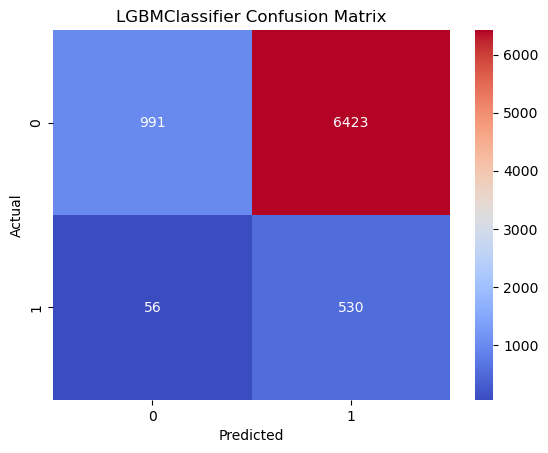

In [936]:
# scaler
scaler=MinMaxScaler()
X_train_scaled=scaler.fit_transform(X_train_encoded)
X_test_scaled=scaler.transform(X_test_encoded)

# resampling technique
res=SMOTE(random_state=seed)
X_train_res,y_train_res=res.fit_resample(X_train_scaled, y_train)

# initialize model with balanced class weights
model = LGBMClassifier(class_weight='balanced', random_state=seed)

# define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# get cross-validated probabilities on the resampled training set
y_probs_cv = cross_val_predict(model, X_train_res, y_train_res, cv=cv, method='predict_proba')[:, 1]

# select threshold
optimal_threshold = 0.12887634804436812

# Refit the model on the entire resampled training set
model.fit(X_train_res, y_train_res)

# Predict probabilities on the test set and apply the optimal threshold
y_probs_test = model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_probs_test >= optimal_threshold).astype(int)

# Evaluate the recall scores
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))

# Confusion matrix
sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True, fmt='', cmap="coolwarm")
plt.title('LGBMClassifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Mean F2-Score: 0.8649

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      7414
           1       0.18      0.16      0.17       586

    accuracy                           0.88      8000
   macro avg       0.56      0.55      0.55      8000
weighted avg       0.88      0.88      0.88      8000



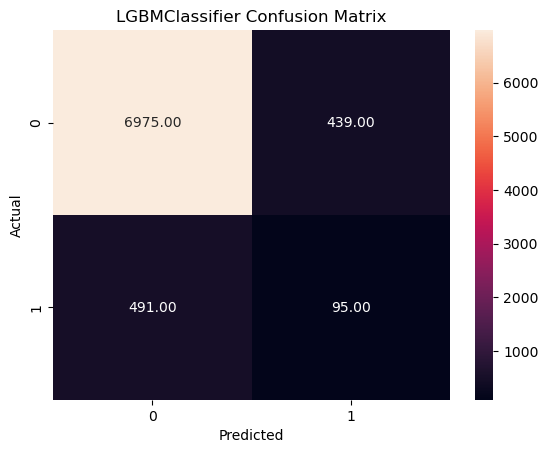

In [917]:
# scaler
scaler=MinMaxScaler()

X_train_scaled=scaler.fit_transform(X_train_encoded)
X_test_scaled=scaler.transform(X_test_encoded)

# Resampling technique (e.g., SMOTETomek)
res = SMOTETomek(random_state=seed)
X_train_res, y_train_res = res.fit_resample(X_train_scaled, y_train)

# Initialize model with balanced class weights
model = LGBMClassifier(class_weight='balanced', random_state=seed)

# Train model
model.fit(X_train_res, y_train_res)

# Predict probabilities on test set for threshold adjustment
y_probs = model.predict_proba(X_test_scaled)[:, 1]

# Adjust threshold to optimize recall for class 1 while retaining reasonable recall for class 0
optimal_threshold=closest_threshold
y_pred = (y_probs >= optimal_threshold).astype(int)

# Evaluate the recall scores
print(classification_report(y_test, y_pred))

sns.heatmap(data=confusion_matrix(y_test,y_pred),annot=True,fmt='.2f')
plt.title('LGBMClassifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

###


# resampling technique
res=SMOTETomek(random_state=seed)
X_train_res,y_train_res=res.fit_resample(X_train_scaled,y_train)

# initialize model with balanced class weights
model=LGBMClassifier(class_weight='balanced', random_state=seed)

# run cross_val_score
cross_val_score(model,X_train_res,y_train_res,scoring='recall',cv=5)

# train model
model.fit(X_train_res,y_train_res)

# predict probabilities on test set for threshold adjustment
y_probs=model.predict_proba(X_test_scaled)[:,1]

threshold=closest_threshold # 0.11...
y_pred=(y_probs >= threshold).astype(int)
    
# extract recall scores
report=classification_report(y_test,
                             y_pred,
                             output_dict=True,
                             zero_division=0) # because of warnings

# extract true positives and false positives
cm=confusion_matrix(y_test,y_pred)

# Predict and evaluate on the test set
y_pred = model.predict(X_test_scaled)
print(f"Mean F2-Score: {scores.mean():.4f}")
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))
sns.heatmap(data=confusion_matrix(y_test,y_pred),annot=True,fmt='.2f')
plt.title('LGBMClassifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Modeling: Layer 2

To recap, the second layer of the modeling will run the full dataset as we want the model to understand which customers the company should keep calling.

In [809]:
X_2.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1


In [ ]:
splits_2,pipeline_2,results_2=\
run_autosklearn_pipeline(X=X_2,
                         y=y,
                         seed=seed,
                         verbose=True,
                         test_size=test_size,
                         save_location='../joblib/',
                         filename='2_pipeline_20240821_layer2',
                         time_for_task=3600)

Categorical and continuous features detected
Preprocessor created
categorical_features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month']
continuous_features: ['age', 'balance', 'day', 'duration', 'campaign']
Training and testing splits created
AutoSklearnClassifier and pipeline created

Training the pipeline... (This may take up to 60 minutes)




In [ ]:
results_2=returnTopModels('../joblib/2_pipeline_20240821_layer2')
results_2

random_forest          23
mlp                     5
liblinear_svc           3
k_nearest_neighbors     2
extra_trees             2
passive_aggressive      1
gaussian_nb             1
bernoulli_nb            1
Name: param_classifier:__choice__, dtype: int64

In [ ]:
pipeline_2=joblib.load('../joblib/2_pipeline_20240821_layer2')
splits_2=joblib.load('../joblib/2_pipeline_20240821_layer2_splits')

In [ ]:
X_2_test=splits_2['X_test']
y_2_test=splits_2['y_test']

y_2_pred,accuracy_2=evaluateModel(X_2_test,y_2_test,pipeline_2,verbose=True)

AutoSklearn accuracy:
93.77%


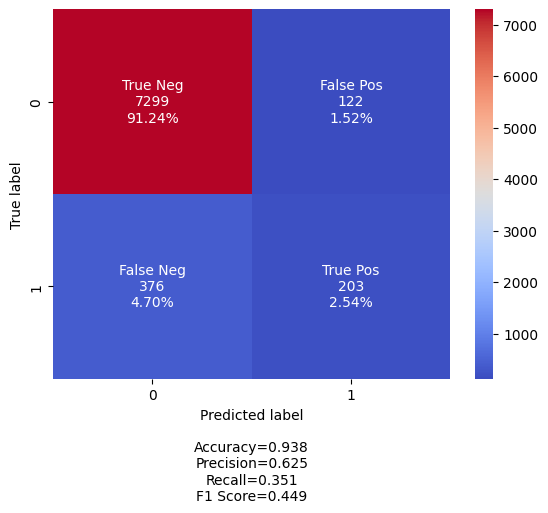

In [ ]:
# view confusion matrix
# the F1-score doesn't show but that's ok
cf_matrix_2=confusion_matrix(y_2_test,y_2_pred)
labels=['True Neg','False Pos','False Neg','True Pos']
make_confusion_matrix(cf=cf_matrix_2,
                      group_names=labels,
                      cmap='coolwarm')

In [ ]:
# view F1-score
creport=classification_report(y_test,y_2_pred)
print(creport)

              precision    recall  f1-score   support

          no       0.95      0.98      0.97      7421
         yes       0.62      0.35      0.45       579

    accuracy                           0.94      8000
   macro avg       0.79      0.67      0.71      8000
weighted avg       0.93      0.94      0.93      8000



This is also a great result.

## Layer 3: Clustering

## Modeling on full dataset

In [302]:
X=df[[col for col in df.columns if col != 'y']]
y=df['y']

In [309]:
y=y.map({'yes':1,'no':0})

In [310]:
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1


In [311]:
data=pd.concat([X,y],axis=1)

In [319]:
cat_cols = list(X.select_dtypes(include='object').columns)
cat_cols.append('day')
print(f'cat_cols:{cat_cols}')

num_cols = list(X.select_dtypes(exclude='object').columns)
num_cols.remove('day')
print(f'num_cols:{num_cols}')

cat_cols:['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day']
num_cols:['age', 'balance', 'duration', 'campaign']


Data is split

Evaluating etc...
Pipeline is created
Evaluating model...
Cross-validation recall scores: [0.3174946  0.33693305 0.30885529 0.34051724 0.36206897]
Mean recall: 0.3332
Fitting model...
Making predictions on training set...

Training Set Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29683
           1       1.00      1.00      1.00      2317

    accuracy                           1.00     32000
   macro avg       1.00      1.00      1.00     32000
weighted avg       1.00      1.00      1.00     32000

Making predictions on testing set...

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7421
           1       0.38      0.36      0.37       579

    accuracy                           0.91      8000
   macro avg       0.66      0.66      0.66      8000
weighted avg       0.91      0.91      0.91      8000



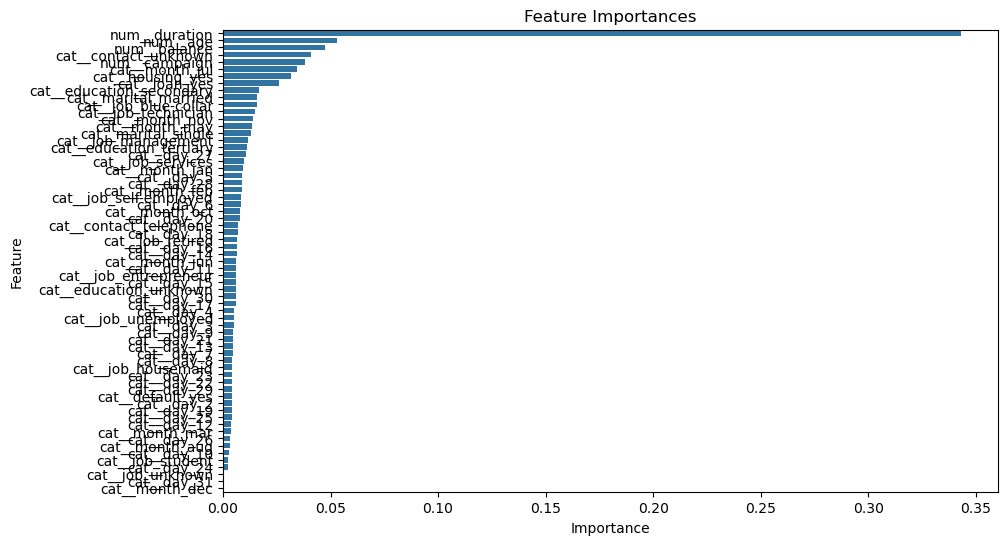


Evaluating xgb...
Pipeline is created
Evaluating model...
Cross-validation recall scores: [0.7537797  0.76241901 0.75161987 0.75       0.71767241]
Mean recall: 0.7471
Fitting model...
Making predictions on training set...

Training Set Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.93      0.97     29683
           1       0.54      1.00      0.70      2317

    accuracy                           0.94     32000
   macro avg       0.77      0.96      0.83     32000
weighted avg       0.97      0.94      0.95     32000

Making predictions on testing set...

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      7421
           1       0.43      0.80      0.56       579

    accuracy                           0.91      8000
   macro avg       0.70      0.86      0.75      8000
weighted avg       0.94      0.91      0.92      8000



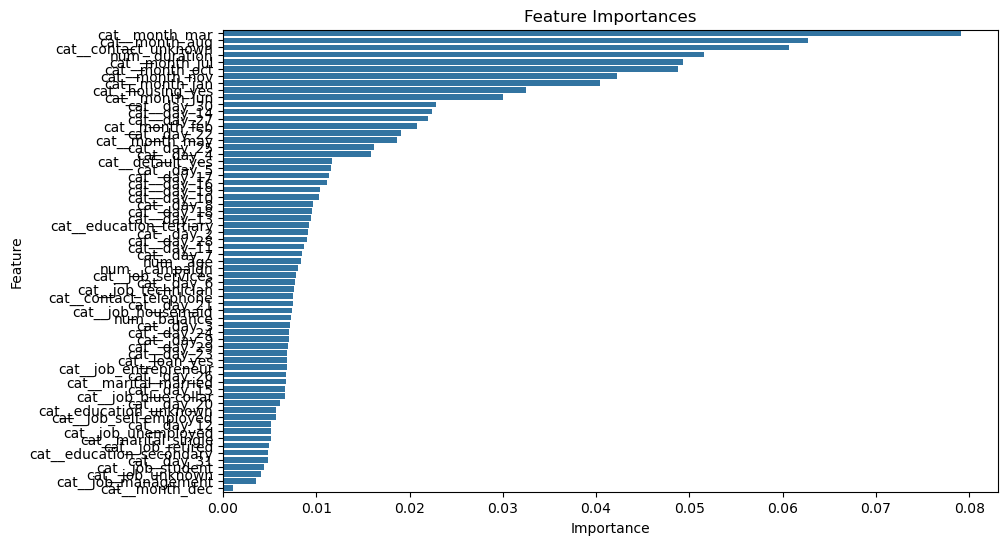


Evaluating dtc...
Pipeline is created
Evaluating model...
Cross-validation recall scores: [0.40388769 0.38444924 0.38660907 0.42672414 0.38793103]
Mean recall: 0.3979
Fitting model...
Making predictions on training set...

Training Set Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29683
           1       1.00      1.00      1.00      2317

    accuracy                           1.00     32000
   macro avg       1.00      1.00      1.00     32000
weighted avg       1.00      1.00      1.00     32000

Making predictions on testing set...

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      7421
           1       0.42      0.44      0.43       579

    accuracy                           0.91      8000
   macro avg       0.69      0.70      0.69      8000
weighted avg       0.92      0.91      0.92      8000



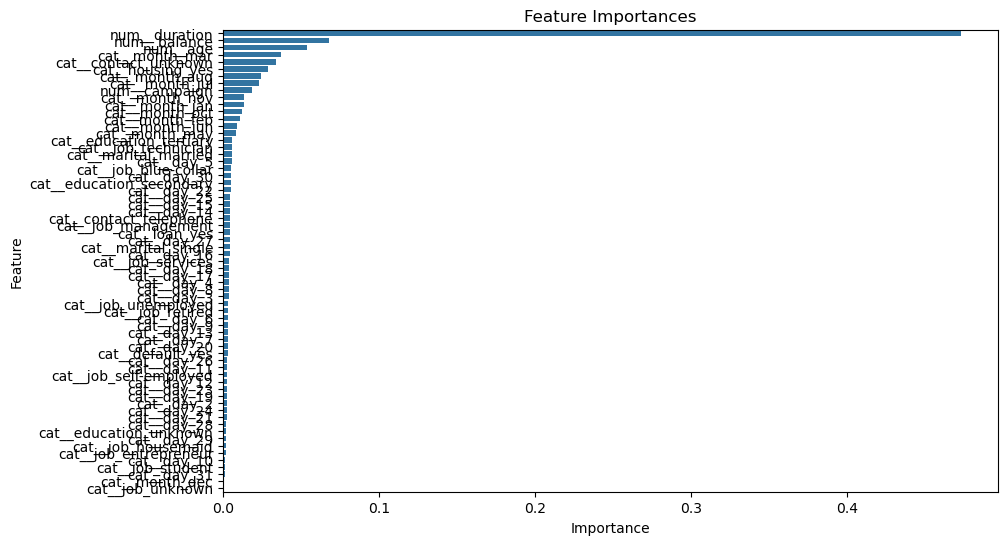


Evaluating rfc...
Pipeline is created
Evaluating model...
Cross-validation recall scores: [0.39956803 0.39308855 0.37796976 0.39224138 0.40517241]
Mean recall: 0.3936
Fitting model...
Making predictions on training set...

Training Set Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29683
           1       1.00      1.00      1.00      2317

    accuracy                           1.00     32000
   macro avg       1.00      1.00      1.00     32000
weighted avg       1.00      1.00      1.00     32000

Making predictions on testing set...

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7421
           1       0.59      0.46      0.52       579

    accuracy                           0.94      8000
   macro avg       0.78      0.72      0.74      8000
weighted avg       0.93      0.94      0.93      8000



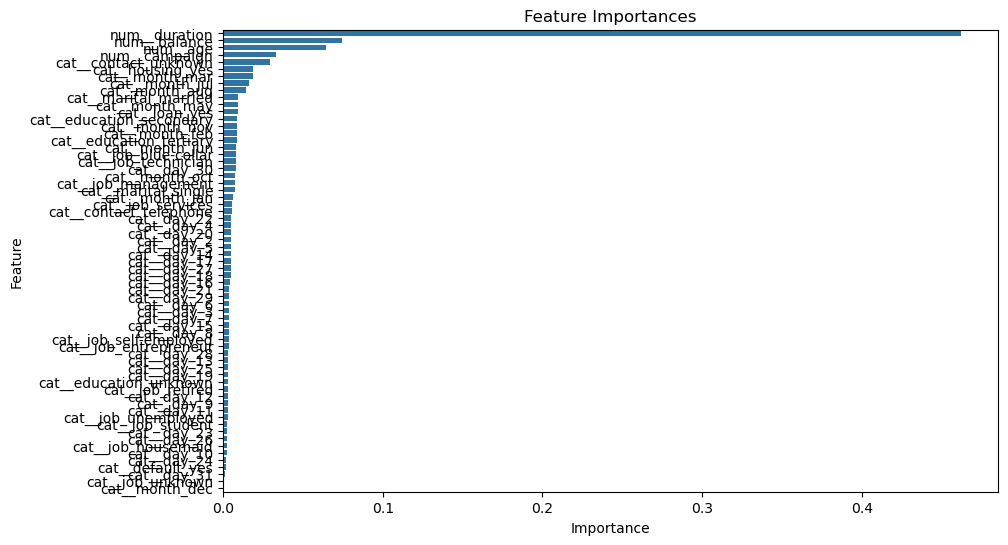


Evaluating lgb...
Pipeline is created
Evaluating model...
Cross-validation recall scores: [0.87688985 0.88336933 0.85529158 0.87715517 0.85560345]
Mean recall: 0.8697
Fitting model...
Making predictions on training set...

Training Set Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     29683
           1       0.41      0.97      0.57      2317

    accuracy                           0.89     32000
   macro avg       0.70      0.93      0.76     32000
weighted avg       0.95      0.89      0.91     32000

Making predictions on testing set...

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      7421
           1       0.38      0.89      0.53       579

    accuracy                           0.89      8000
   macro avg       0.68      0.89      0.73      8000
weighted avg       0.95      0.89      0.91      8000



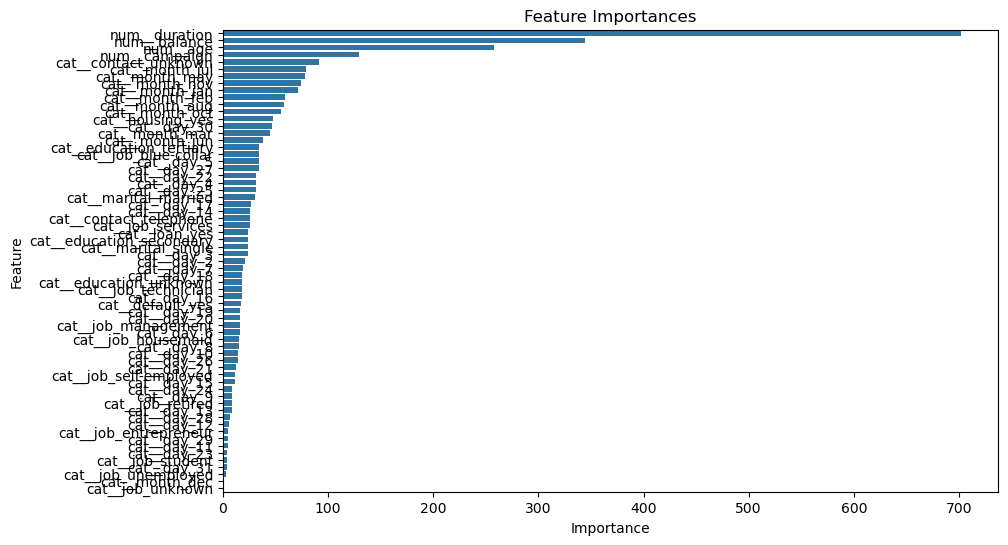


Evaluating lrx...
Pipeline is created
Evaluating model...
Cross-validation recall scores: [0.85961123 0.87041037 0.84233261 0.875      0.8512931 ]
Mean recall: 0.8597
Fitting model...
Making predictions on training set...

Training Set Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.87      0.92     29683
           1       0.34      0.87      0.49      2317

    accuracy                           0.87     32000
   macro avg       0.67      0.87      0.71     32000
weighted avg       0.94      0.87      0.89     32000

Making predictions on testing set...

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      7421
           1       0.35      0.88      0.50       579

    accuracy                           0.87      8000
   macro avg       0.67      0.88      0.72      8000
weighted avg       0.94      0.87      0.90      8000


Done!


In [321]:
target_column_name = 'y'

# Split the data
X_train, X_test, y_train, y_test = split_data(data=data, target_column_name='y',random_state=seed)

# Evaluate models
for model_name, model in classifier_map.items():
    print(f"\nEvaluating {model_name}...")
    
    # Create a pipeline for each model
    pipeline = create_pipeline(model,cat_cols,random_state=seed)
    
    # Evaluate using cross-validation on the training set
    evaluate_model(pipeline,X_train,y_train,random_state=seed)
    
    # Perform final evaluation on the test set
    final_evaluation(pipeline,X_train,y_train,X_test,y_test)

print("\nDone!")